# Лабораторная работа 3. Линейные методы.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя. Обратите внимание, что мы не ставим оценку за просто написанный код, корректная работоспособность которого не подтверждена экспериментами.

## Логистическая регрессия

В этом пункте мы будем рассматривать бинарную классификацию, где метки классов лежат в множестве $\{-1, 1\}$. 

Задачу обучения регуляризованной логистической регрессии можно записать следующим образом:

$$ \dfrac{1}{N}\sum_{i=1}^N \log(1 + \exp(-\langle w, x_i \rangle y_i)) + \dfrac{C}{2}\lVert w \rVert^2  \to \min_w$$

Обучение данной модели сводится к нахождению параметров модели $w$, которое производится с помощью метода градиентного спуска. 

В данном случае градиентный шаг будет заключаться в обновлении вектора весов по следующей формуле:

$$w := w + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w, x_i \rangle y_i)}\Big) - \eta Cw$$

где $\eta > 0$ — размер шага.

В общем случае метод градиентного спуска имеет некоторые недостатки:
- попадание в локальные минимумы
- неочевидность критерия останова
- выбор размера шага
- начальная инициализация весов

В этой части лабораторной работы мы предложим вам реализовать метод градиентного спуска, а также рассмотрим некоторые его модификаций.

In [217]:
import numpy as np
import pandas as pd
import pylab as plt
import random
%matplotlib inline

### Задание

Сгенерируйте выборку из 1000 точек с 20 признаками, на которой будете проводить эксперименты. Мы рекомендуем воспользоваться функцией [make_classification](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification) из пакета sklearn. Обратите внимание, что метки классов для данной задачи должны быть из множества {-1, 1} (по умолчанию make_classification возвращает метки из множества {0, 1}).

In [106]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000,n_features=20)

In [107]:
np.place(y,y==0,-1)

**(2.5 балла) Задание 1.** 

Реализуйте градиентный спуск и протестируйте его для случая логистической регрессии на ранее сгенерированной выборке. Для сравнения качества разных подходов используйте значение оптимизируемого функционала.

В качестве критерия останова мы предлагаем использовать следующие условия:
 - евклидова норма разности текущего и нового векторов весов стала меньше 1e-6
 - ограничить число итераций (например, 10000)
 
Для начальной инициализации весов можно сравнить следующие подходы:
 - нулевая начальная инициализация
 - случайная начальная инициализация
 
Выполните следующие пункты и прокомментируйте полученный результат:
- Рассмотрите, как влияет размер шага на сходимость.
- Сравните, влияет ли наличие регуляризации на скорость сходимости и качество.
- Постройте график качества оптимизируемого функционала в зависимости от номера итерации (при правильной реализации и подходящем размере шага он должен убывать).
- Влияет ли выбор начальной инициализации весов на скорость и качество?

In [193]:
def norm(x):
    return np.sqrt(np.sum(np.square(x)))


class MyAwesomeLogisticRegression:

    def __init__(self, num_of_features, step, reg_constant, init_weights):
        self.M = num_of_features
        self.step = step
        self.reg_constant = reg_constant
        self.init_weights(init_weights)

    def init_weights(self, init_weights, seed=None):
        np.random.seed(seed)
        
        if (init_weights==0):
            self.W = np.zeros(shape=self.M)
        
        if (init_weights==1):
            self.W = np.random.normal(size=self.M)

    def predict(self, X):
        return np.dot(X, self.W)

    def loss(self, X, y):
        return np.mean(np.log(1 + np.exp(-self.predict(X)*y)))+self.reg_constant*norm(self.W)*norm(self.W)/2

    def loss_grad(self, X, y):
        return -np.mean(y*X.T*(1 - 1/(1+np.exp(-self.predict(X)*y))),axis=1)+self.reg_constant*self.W


    def train(self, X, y, Xval, yval):

        err = {
            'train': [],
            'val': [],
        }
        
        eps=1e-6
        delta_W=1
        t=1
        
        while t < 10000 and delta_W>eps:
            t += 1
            
            W0=self.W.copy()

            err['train'].append(self.loss(X, y))
            err['val'].append(self.loss(Xval, yval))

            dW = self.loss_grad(X, y)
            self.W -= dW * self.step
            
            delta_W=norm(self.W-W0)
            

        err['train'].append(self.loss(X, y))
        err['val'].append(self.loss(Xval, yval))
        
        return err

    

In [194]:
from sklearn.cross_validation import train_test_split 
Xtr, Xval, ytr, yval = train_test_split(np.insert(X, 0, 1, axis=1), y, test_size=0.2) 
Xtr.shape, Xval.shape

((800, 21), (200, 21))

In [195]:
self=MyAwesomeLogisticRegression(Xtr.shape[1],0.01,1,1)
err=self.train(Xtr,ytr,Xval,yval)

In [203]:
for step in [0.001,0.01,0.1,0.5,1,5,10]:
        self=MyAwesomeLogisticRegression(Xtr.shape[1],step,0,1)
        err=self.train(Xtr,ytr,Xval,yval)
        print('step:',step,'err:',err['val'][-1],'t:',len(err['val']))

step: 0.001 err: 0.571302089492 t: 10000
step: 0.01 err: 0.397039092309 t: 10000
step: 0.1 err: 0.394338407645 t: 2777
step: 0.5 err: 0.394366367837 t: 748
step: 1 err: 0.394359526919 t: 379
step: 5 err: 0.463821964697 t: 10000
step: 10 err: 0.977506035565 t: 10000


Качество и скорость сходимости зависят от размера шага. При маленьком шаге для достижения минимума необходимо много итераций, что скажется на скоросте сходимости. Если же количество итераций ограничено, они могут закончиться раньше, чем достигнется минимум. Или произойдет застревание в локальном минимуме.

In [205]:
for reg_constant in [0,0.01,0.1,1,10]:
        self=MyAwesomeLogisticRegression(Xtr.shape[1],0.1,reg_constant,1)
        err=self.train(Xtr,ytr,Xval,yval)
        print('reg_constant:',reg_constant,'err:',err['val'][-1],'t:',len(err['val']))

reg_constant: 0 err: 0.394338353926 t: 2536
reg_constant: 0.01 err: 0.389448717325 t: 7350
reg_constant: 0.1 err: 0.44463905902 t: 902
reg_constant: 1 err: 0.589183384367 t: 120
reg_constant: 10 err: 0.675402851308 t: 8


In [206]:
self=MyAwesomeLogisticRegression(Xtr.shape[1],0.1,0.01,1)
err=self.train(Xtr,ytr,Xval,yval)

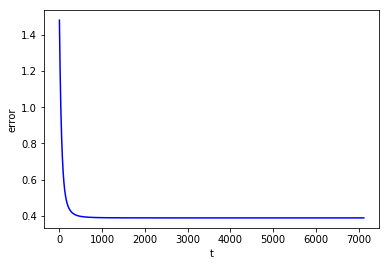

In [213]:
x,y=range(len(err['val'])),np.array(err['val'])
plt.plot(x,y,'b')
plt.xlabel('t')
plt.ylabel('error')
plt.show()

In [215]:
for init_weights in [0,1]:
    self=MyAwesomeLogisticRegression(Xtr.shape[1],0.1,0.01,init_weights)
    err=self.train(Xtr,ytr,Xval,yval)
    print('init_weights:',init_weights,'err_first:',err['val'][0],'err_last:',err['val'][-1],'t:',len(err['val']))

init_weights: 0 err_first: 0.69314718056 err_last: 0.389438019073 t: 1517
init_weights: 1 err_first: 2.11172854455 err_last: 0.389448717326 t: 6184


Метод градиентного спуска может быть весьма трудозатратен в случае большого размера обучающей выборки. Поэтому обычно используют метод стохастического градиентного спуска, где на каждой итерации выбирается случайный объект из обучающей выборки и обновление весов происходит сразу по этому объекту. 

**(1 балл) Задание 2.** 

Реализуйте метод стохастического градиентного спуска (sgd). В этом случае вы можете выбрать наиболее удачный функционал, исходя из предыдущего пункта (с регуляризацией, без), а также схему начальной инициализации весов.

- Посмотрите, как влияет размер шага на сходимость
- Постройте график качества оптимизируемого функционала в зависимости от номера итерации 

Сравните рассмотренные методы (градиентный спуск и sgd) между собой с точки зрения скорости сходимости и качества.

In [236]:
class MyAwesomeLogisticRegressionStochastic:

    def __init__(self, num_of_features, step, reg_constant):
        self.M = num_of_features
        self.step = step
        self.reg_constant = reg_constant
        self.init_weights(init_weights)

    def init_weights(self, seed=None):
        self.W = np.zeros(shape=self.M)
    

    def predict(self, X):
        return np.dot(X, self.W)

    def loss(self, X, y):
        return np.mean(np.log(1 + np.exp(-self.predict(X)*y)))+self.reg_constant*norm(self.W)*norm(self.W)/2

    def loss_grad(self, X, y):
        i=random.randrange(X.shape[0])
        return -y[i]*X[i]*(1 - 1/(1+np.exp(-self.predict(X[i])*y[i])))+self.reg_constant*self.W


    def train(self, X, y, Xval, yval):

        err = {
            'train': [],
            'val': [],
        }
        
        eps=1e-6
        delta_W=1
        t=1
        
        while t < 10000 and delta_W>eps:
            t += 1
            
            W0=self.W.copy()

            err['train'].append(self.loss(X, y))
            err['val'].append(self.loss(Xval, yval))

            dW = self.loss_grad(X, y)
            self.W -= dW * self.step
            
            delta_W=norm(self.W-W0)
            

        err['train'].append(self.loss(X, y))
        err['val'].append(self.loss(Xval, yval))
        
        return err


In [237]:
for step in [0.001,0.01,0.1,0.5,1,5,10]:
        self=MyAwesomeLogisticRegressionStochastic(Xtr.shape[1],step,0.01)
        err=self.train(Xtr,ytr,Xval,yval)
        print('step:',step,'err:',err['val'][-1],'t:',len(err['val']))

step: 0.001 err: 0.366129110098 t: 10000
step: 0.01 err: 0.39087260513 t: 10000
step: 0.1 err: 0.392237694276 t: 10000
step: 0.5 err: 0.983479540162 t: 10000
step: 1 err: 1.92250230682 t: 10000
step: 5 err: 14.6490844427 t: 10000
step: 10 err: 25.5611919403 t: 10000


In [238]:
self=MyAwesomeLogisticRegressionStochastic(Xtr.shape[1],0.001,0.01)
err=self.train(Xtr,ytr,Xval,yval)

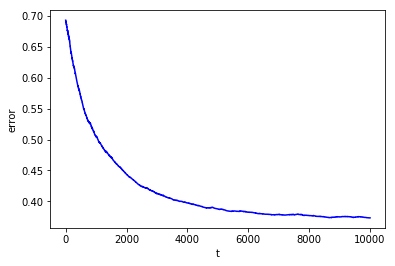

In [239]:
x,y=range(len(err['val'])),np.array(err['val'])
plt.plot(x,y,'b')
plt.xlabel('t')
plt.ylabel('error')
plt.show()

Между обновлением вектор весов по всей выборке и на одном объекте есть промежуточный подход — выбирать некоторое случайное подмножество объектов и обновлять веса по нему. Такой подход называется mini-batch. Мы не будем реализовывать этот подход в данной работе, однако иногда его бывает осмысленно использовать на практике. 

Один из недостатков sgd состоит в том, что он может не доходить до локального оптимального решения, а осциллировать в окресности. 

![](http://sebastianruder.com/content/images/2015/12/without_momentum.gif)

Для решения этой проблемы существуют методы, позволяющие устранить этот недостаток, а также ускорить сходимость. Рассмотрим некоторые из них.

![](http://nghenglim.github.io/images/2015061300.png)

### Momentum

Этот метод позволяет направить sgd в нужной размерности и уменьшить осцилляцию. 

В общем случае он будет выглядеть следующим образом: 

$$ v_t = \gamma v_{t - 1} + \eta \nabla_{\theta}{J(\theta)}$$
$$ \theta = \theta - v_t$$

где

 - $\theta$ — вектор параметров (в нашем случае — $w$)
 - $J$ — оптимизируемый функционал
 - $\gamma$ — momentum term (обычно выбирается 0.9)
 
### Adagrad 

Одной из сложностей является выбор размера шага (*learning rate*). Основное его отличие в том что размер шага определяется для каждого параметра индивидуально. Этот метод хорошо работает с разреженными данными большого объема. 

Обозначим градиент по параметру $\theta_i$ на итерации $t$ как $g_{t,i} = \nabla_{\theta}J(\theta)$. 

В случае sgd обновление параметра $\theta_i$ будет выглядеть следующим образом:

$$ \theta_{t+1, i} = \theta_{t, i} - \eta \cdot g_{t,i}$$

А в случае Adagrad общий шаг $\eta$ нормируется на посчитанные ранее градиенты для данного параметра:

$$ \theta_{t+1, i} = \theta_{t, i} - \dfrac{\eta}{\sqrt{G_{t,ii} + \varepsilon}} \cdot g_{t,i},$$

где $G_t$ — диагональная матрица, где каждый диагональный элемент $i,i$ — сумма квадратов градиентов для $\theta_{i}$ до $t$-ой итерации. $\varepsilon$ — параметр, позволяющий избежать деления на 0 (обычно выбирается около *1e-8*).

Так как матрица $G_t$ диагональна, в векторном виде это будет выглядеть следующим образом ($\odot$ — матричное умножение):

$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{G_t + \varepsilon}} \odot g_t $$

### Adadelta

Adadelta, в отличии от Adagrad, рассматривает не все предыдущие значения градиентов, а только последние $k$. Кроме того, сумма градиентов определяется как уменьшающееся среднеее всех предыдущих квадратов градиентов. Текущее среднее $E[g^2]_t$ на итерации $t$ будет вглядеть следующим образом:

$$ E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma)g_t^2 $$

здесь $\gamma$ аналогична параметру из метода Momentum.

Тогда обновление весов можно записать следующим образом:

$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Перепишем это немного по-другому:

$$ \theta_{t+1} = \theta_{t} + \Delta \theta_t$$ 
$$\Delta \theta_t = - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Аналогично среднему для градиентов определим среднее для параметров $\theta$:

$$ E[\Delta \theta^2]_t = \gamma E[\Delta \theta^2]_{t-1} + (1-\gamma)\Delta \theta^2 $$

Введем обозначение $RMS[p]_t = \sqrt{E[p]_t + \varepsilon}$

Тогда Adadelta выглядит следующим образом:

$$\Delta \theta_t = - \dfrac{RMS[\Delta \theta^2]}{RMS[ga^2]} g_t $$ 
$$ \theta_{t+1} = \theta_{t} + \Delta \theta_t$$ 


Более подробно об этих и других способах оптимизации можно прочитать:
 - [здесь](http://sebastianruder.com/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms) очень хорошее описание различных способов оптимизации, в этом задании мы опираемся на терминологию из данной статьи
 - оригинальная статья про [momentum](http://brahms.cpmc.columbia.edu/publications/momentum.pdf)
 - оригинальная статья про [adagrad](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)
 - оригинальная статья про [adadelta](http://arxiv.org/pdf/1212.5701v1.pdf)
 - википедия про [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) и [adagrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad)
 - [визуализация](http://imgur.com/a/Hqolp) про сравнение разных способов оптимизации

### Задание 3.

Реализуйте метод оптимизации *Momentum* **(0.5 балла)** и один из *Adagrad*/*Adadelta* **(1 балл)**. 
- Сравните с классическим sgd. 
- Посмотрите, как значение параметра вдияет $\gamma$ на скорость сходимости и качество в методе *Momentum*.
- Дало ли преимущество использование адаптивного шага в методе *Adagrad*/*Adadelta*?

In [259]:
class MyAwesomeLogisticRegressionStochasticMomentum:

    def __init__(self, num_of_features, step, reg_constant, momentum_term):
        self.M = num_of_features
        self.step = step
        self.reg_constant = reg_constant
        self.init_weights(init_weights)
        self.momentum_term = momentum_term

    def init_weights(self, seed=None):
        self.W = np.zeros(shape=self.M)
    

    def predict(self, X):
        return np.dot(X, self.W)

    def loss(self, X, y):
        return np.mean(np.log(1 + np.exp(-self.predict(X)*y)))+self.reg_constant*norm(self.W)*norm(self.W)/2

    def loss_grad(self, X, y):
        i=random.randrange(X.shape[0])
        return -y[i]*X[i]*(1 - 1/(1+np.exp(-self.predict(X[i])*y[i])))+self.reg_constant*self.W


    def train(self, X, y, Xval, yval):

        err = {
            'train': [],
            'val': [],
        }
        
        eps=1e-4
        delta_W=1
        t=1
        dW=np.zeros(shape=self.M)
        
        while t < 10000 and delta_W>eps:
            t += 1
            
            W0=self.W.copy()

            err['train'].append(self.loss(X, y))
            err['val'].append(self.loss(Xval, yval))

            dW = self.momentum_term * dW + self.step * self.loss_grad(X, y)
            self.W -= dW
            
            delta_W=norm(self.W-W0)
            

        err['train'].append(self.loss(X, y))
        err['val'].append(self.loss(Xval, yval))
        
        return err


In [261]:
for momentum_term in [0,0.1,0.2,0.4,0.6,0.8,0.9]:
        self=MyAwesomeLogisticRegressionStochasticMomentum(Xtr.shape[1],0.001,0.01,momentum_term)
        err=self.train(Xtr,ytr,Xval,yval)
        print('momentum_term:',momentum_term,'err:',err['val'][-1],'t:',len(err['val']))

momentum_term: 0 err: 0.404710082265 t: 3376
momentum_term: 0.1 err: 0.400213228685 t: 3040
momentum_term: 0.2 err: 0.37849221721 t: 4921
momentum_term: 0.4 err: 0.368760131976 t: 5963
momentum_term: 0.6 err: 0.372758216601 t: 8472
momentum_term: 0.8 err: 0.38516603055 t: 10000
momentum_term: 0.9 err: 0.393443589598 t: 10000


In [321]:
class MyAwesomeLogisticRegressionStochasticAdaGrad:

    def __init__(self, num_of_features, step, reg_constant):
        self.M = num_of_features
        self.step = step
        self.reg_constant = reg_constant
        self.init_weights(init_weights)

    def init_weights(self, seed=None):
        self.W = np.zeros(shape=self.M)
    

    def predict(self, X):
        return np.dot(X, self.W)

    def loss(self, X, y):
        return np.mean(np.log(1 + np.exp(-self.predict(X)*y)))+self.reg_constant*norm(self.W)*norm(self.W)/2

    def loss_grad(self, X, y):
        i=random.randrange(X.shape[0])
        return -y[i]*X[i]*(1 - 1/(1+np.exp(-self.predict(X[i])*y[i])))+self.reg_constant*self.W


    def train(self, X, y, Xval, yval):

        err = {
            'train': [],
            'val': [],
        }
        
        eps=1e-4
        delta_W=1
        t=1
        dW=[]
        
        while t < 10000 and delta_W>eps:
            t += 1
            
            W0=self.W.copy()

            err['train'].append(self.loss(X, y))
            err['val'].append(self.loss(Xval, yval))

            dW.append(self.loss_grad(X, y))
            
            self.W -= self.step * (1/np.sqrt(np.sum(np.array(dW)*np.array(dW),axis=0)+eps)) * dW[-1]
            
            delta_W=norm(self.W-W0)
            

        err['train'].append(self.loss(X, y))
        err['val'].append(self.loss(Xval, yval))
        
        return err


In [331]:
self=MyAwesomeLogisticRegressionStochasticAdaGrad(Xtr.shape[1],0.1,0.01)
err=self.train(Xtr,ytr,Xval,yval)

In [332]:
err['val'][-1],len(err['val'])

(0.39282071510876643, 4513)

## Линейная регрессия

![](http://66.147.244.197/~globerov/introspectivemode/wp-content/uploads/2012/08/regression-265x300.jpeg)

Метод градиентного спуска позволяет оптимизировать произвольные функции. Например, рассмотрим задачу линейной регрессии, где $y \in \mathbb{R}$, а алгоритм будет иметь вид $a(x) = \langle w, x\rangle$. В случае метода наименьших квадратов оптимизируемый функционал можно записать следующим образом:

$$ \sum_{i=1}^N (\langle w, x_i \rangle - y_i) ^ 2 \to \min_w$$

Эта задача интересна тем, что для нее можно выписать аналитическое решение. Попробуем сравнить два подхода.

### Задание 4.

Сгенерируйте выборку из 600 точек с двумя признаками для задачи регрессии, воспользовавшись функцией [make_regression](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html#sklearn.datasets.make_regression). 

In [345]:
from sklearn.datasets import make_regression
X, y, coef = make_regression(n_samples=600,n_features=2,coef=True)

**(0.5 балла)** Выпишите, как выглядит точное решение задачи линейной регрессии. Решите задачу регрессии с помощью этого подхода без использования и с использованием регуляризации. Есть ли недостатки у такого подхода к решению задачи?

In [393]:
W=np.dot(X.T,y)/(np.sum(X*X,axis=0))
b=np.mean(y)
a=np.dot(X,W)+b
np.sum((a-y)*(a-y))

3262.0525116450472

In [394]:
coef,W

(array([ 91.88113474,  13.61964402]), array([ 91.65466602,  11.71347397]))

In [403]:
C=0.5
W=np.dot(X.T,y)/(np.sum(X*X,axis=0)+C)
b=np.sum(y)/(X.shape[0]+C)
a=np.dot(X,W)+b
np.sum((a-y)*(a-y))

3301.1556877281187

In [404]:
coef,W

(array([ 91.88113474,  13.61964402]), array([ 91.58251734,  11.70197212]))

**(0.5 балла) ** Примените метод стохастического градиентного спуска из задания ранее. Сильно ли отличается полученный вектор параметров по сравнению с точным решением? 

In [424]:
class MyAwesomeLinearRegressionStochastic:

    def __init__(self, num_of_features, step, reg_constant):
        self.M = num_of_features
        self.step = step
        self.reg_constant = reg_constant
        self.init_weights(init_weights)

    def init_weights(self, seed=None):
        self.W = np.zeros(shape=self.M)
    

    def predict(self, X):
        return np.dot(X, self.W)

    def loss(self, X, y):
        return np.mean(np.square(y - self.predict(X))) / 2 + self.reg_constant*norm(self.W)*norm(self.W) / 2

    def loss_grad(self, X, y):
        i=random.randrange(X.shape[0])
        return (self.predict(X[i])-y[i])*X[i] + self.reg_constant * self.W


    def train(self, X, y, Xval, yval):

        err = {
            'train': [],
            'val': [],
        }
        
        eps=1e-6
        delta_W=1
        t=1
        
        while t < 1000 and delta_W>eps:
            t += 1
            
            W0=self.W.copy()

            err['train'].append(self.loss(X, y))
            err['val'].append(self.loss(Xval, yval))

            dW = self.loss_grad(X, y)
            self.W -= dW * self.step
            
            delta_W=norm(self.W-W0)
            

        err['train'].append(self.loss(X, y))
        err['val'].append(self.loss(Xval, yval))
        
        print(err['val'][-1])
        
        return self.W


In [425]:
Xtr, Xval, ytr, yval = train_test_split(np.insert(X, 0, 1, axis=1), y, test_size=0.2) 
Xtr.shape, Xval.shape

((480, 3), (120, 3))

In [427]:
self=MyAwesomeLinearRegressionStochastic(Xtr.shape[1],0.1,0.01)
W_sgd=self.train(Xtr,ytr,Xval,yval)

42.9062466158


In [437]:
W_sgd,np.append(b,W),np.append(np.mean(y),coef)

(array([ -0.11002968,  90.55145274,  13.4823495 ]),
 array([ -1.49093155,  91.58251734,  11.70197212]),
 array([ -1.49217399,  91.88113474,  13.61964402]))

К сожалению, линейная регрессия позволяет хорошо восстанавливать *линейные* зависимости, однако в общем случае хуже работает с более сложными данными. Это хорошо можно увидеть на следующем примере.

Пусть исходная зависимость имеет вид $y = x \cdot sin(x)$. Сгенерируем несколько точек:

In [438]:
from sklearn.cross_validation import train_test_split

In [439]:
X = np.linspace(0, 10, 100)
y = X * np.sin(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

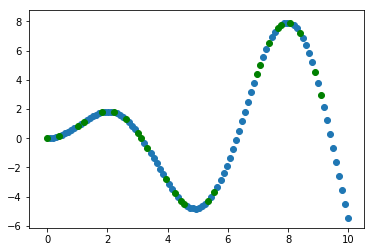

In [440]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')

Если теперь к полученным данным применить модель линейной регрессии, то получим следующее решение:

In [441]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()
lr.fit(X_train[:, np.newaxis], y_train)

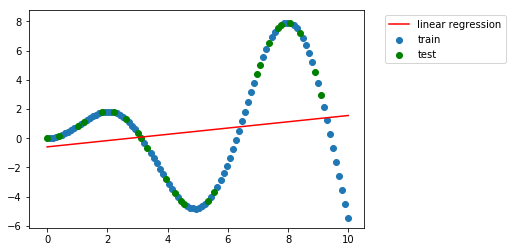

In [443]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')
y_plot = lr.predict(X[:, np.newaxis])
_ = plt.plot(X, y_plot, c='r')
_ = plt.legend(('linear regression', 'train', 'test'), bbox_to_anchor=(1.05, 1), loc=2)

Качество модели регрессии можно оценивать с помощью некоторых метрик, например, $MSE = \sum_{i=1}^l(a(x_i) - y_i)^2$. В данном случае оно равно:

In [444]:
from sklearn.metrics import mean_squared_error

In [445]:
mean_squared_error(y_test, lr.predict(X_test[:, np.newaxis])) 

14.759977502823235

Построенное решение совсем отдаленно напоминает исходную зависимость. Чтобы как-то исправить это, одним из подходов является добавление всех попарных произведений признаков, а также степеней: $x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2, \dots$

### Задание 5.

**(0.5 балла)** Воспользуйтесь классом [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures) и добавьте к данным зависимости $y = x \cdot sin(x)$ различные полиномы.

 - рассмотрите, как степень полинома (от 1 до 20) влияет на качество
 - изобразите на графике предсказание аналогично линейной регрессии
 - сравните этот подход с функцией [polyfit](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.polyfit.html)

В чем могут быть недостатки такого подхода?

In [518]:
from sklearn.preprocessing import PolynomialFeatures

In [519]:
X = np.linspace(0, 10, 100)
y = X * np.sin(X)

In [522]:
X=X.reshape(100, 1)

In [523]:
for deg in range(1,20):
    polynom = PolynomialFeatures(deg)
    poly=polynom.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(poly, y, random_state=42)
    lr.fit(X_train, y_train)
    print('deg:',deg,'error:',mean_squared_error(y_test, lr.predict(X_test)) )

deg: 1 error: 14.7599775028
deg: 2 error: 13.6939938774
deg: 3 error: 11.0905318302
deg: 4 error: 1.94641536663
deg: 5 error: 1.55072080309
deg: 6 error: 0.182814448645
deg: 7 error: 0.0347504887865
deg: 8 error: 0.00560394054472
deg: 9 error: 0.000400687163867
deg: 10 error: 6.72915299527e-05
deg: 11 error: 2.22334373467e-06
deg: 12 error: 2.81186338036e-07
deg: 13 error: 6.60086855788e-09
deg: 14 error: 1.67126455506e-05
deg: 15 error: 0.000122596711198
deg: 16 error: 0.0425403714461
deg: 17 error: 0.0886547994744
deg: 18 error: 0.159998411787
deg: 19 error: 0.149018325867


In [534]:
for deg in [[3,'r'],[10,'g'],[18,'b']]:
    print(deg[0])

3
10
18


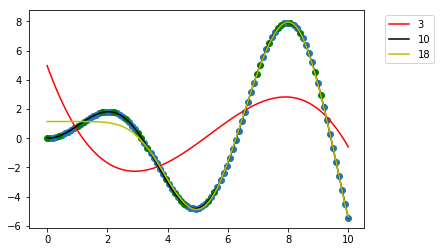

In [545]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')

for deg in [[3,'r'],[10,'k'],[18,'y']]:
    polynom = PolynomialFeatures(deg[0])
    poly=polynom.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(poly, y, random_state=42)
    lr.fit(X_train, y_train)
    y_plot = lr.predict(poly)
    _ = plt.plot(X, y_plot, c=deg[1])


_ = plt.legend(('3', '10', '18'), bbox_to_anchor=(1.05, 1), loc=2)

## Линейный SVM

Вернемся к задаче бинарной классификации. Будем обозначать обочающую выборку $\{(x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

SVM обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geqslant 1 - \xi_n, \quad \xi_n \geqslant 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $y_n (\boldsymbol w^T \boldsymbol x_n + b) \geqslant 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели. Этот гиперпараметр отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

Особенность этого метода в том, что он имеет решение, которое может быть найдено, используя квадратичное прогаммирование. В этом задании мы не будем сводить данную задачу к задаче квадратичного программирования, а воспользуемся готовой реализацией из библиотеки sklearn.

### Особенности реализации

Обратите внимание, что в библиотеке sklearn можно найти 2 реализации линейного SVM: [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) и [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) с ядровой функцией *linear*. Эти реализации имеют различие в библиотеках, на которых основаны: в первом случае используется библиотека *liblinear*, во втором — *libsvm*. Каждая из библотек имеет свои плюсы, поэтому перед применением стоит определиться, какая из реализаций подходит больше. Обратите внимание, что это различие есть только для линейного SVM.

В данном задании рекомендуем использовать класс [sklearn.svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) с параметром *kernel='linear'*.

### Задание 6.

Сгенерируйте три случайные двумерные выборки для бинарной классификации (хотя бы по 400 точек в каждой):
- с линейно разделимыми классами
- с хорошо разделимыми классами, но не линейно
- с плохо разделимыми классами по имеющимся признакам
    
Для генерации случайной выборки можно воспользоваться функциями, которые находятся в пакете [sklearn.datasets](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets). Для того, чтобы выборки не менялись при перезапуске ноутбука, фиксируйте параметр *random_state*.

In [546]:
from sklearn.datasets import make_moons, make_circles, make_classification

In [703]:
X, y = make_classification(n_samples=400,n_features=2, n_redundant=0, n_informative=2,
                           random_state=3, n_clusters_per_class=1)
i=np.where(y==1)
j=np.where(y==0)
X[i] -=  0.5
X[j] +=  0.5
linearly_separable = (X, y)

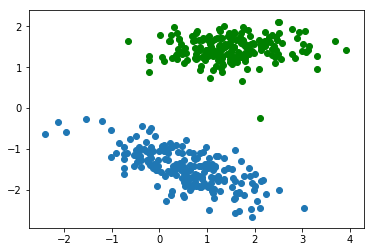

In [704]:
_ = plt.scatter(X[i].T[0], X[i].T[1])
_ = plt.scatter(X[j].T[0], X[j].T[1], c='g')

In [686]:
X, y = make_moons(n_samples=400,noise=0.1, random_state=2)
moons = (X, y)

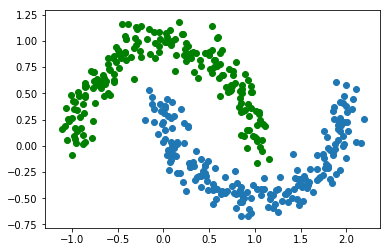

In [676]:
i=np.where(y==1)
j=np.where(y==0)
_ = plt.scatter(X[i].T[0], X[i].T[1])
_ = plt.scatter(X[j].T[0], X[j].T[1], c='g')

In [681]:
X, y = make_circles(n_samples=400,noise=0.5, random_state=2)
circles = (X, y)

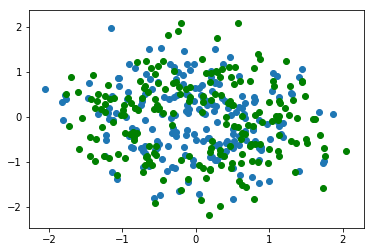

In [682]:
i=np.where(y==1)
j=np.where(y==0)
_ = plt.scatter(X[i].T[0], X[i].T[1])
_ = plt.scatter(X[j].T[0], X[j].T[1], c='g')

**(0.5 балла)** Протестируйте линейный SVM  на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Проделайте это для разных значений параметра $C$.

In [683]:
from sklearn import svm

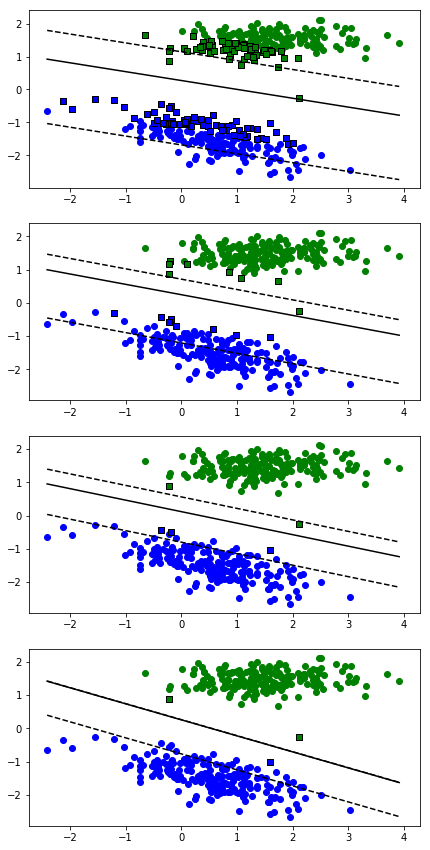

In [792]:
fig, axes = plt.subplots(4,1,figsize=(7,15))
C=[0.005,0.1,1,10]
X,y = linearly_separable

for k in range(4):
    clf = svm.SVC(C=C[k],kernel='linear')
    clf.fit(X, y) 
    w = clf.coef_[0]
    a = - w[0] / w[1]
    xx = np.linspace(X.T[0].min(), X.T[0].max())
    yy = a * xx - clf.intercept_[0] / w[1]
    yy_up = a * xx - (-1 - clf.intercept_[0]) / w[1]
    yy_down = a * xx - (1 - clf.intercept_[0]) / w[1]


    i=np.where(y==1)
    j=np.where(y==0)
    ii=np.where(y[clf.support_]==1)
    jj=np.where(y[clf.support_]==0)

    axes[k].scatter(X[i].T[0], X[i].T[1], c='b')
    axes[k].scatter(X[j].T[0], X[j].T[1], c='g')
    axes[k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='b',marker='s', edgecolors='k')
    axes[k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='g',marker='s', edgecolors='k')
    axes[k].plot(xx, yy,'k-')
    axes[k].plot(xx, yy_up,'k--')
    axes[k].plot(xx, yy_down,'k--')
plt.show()

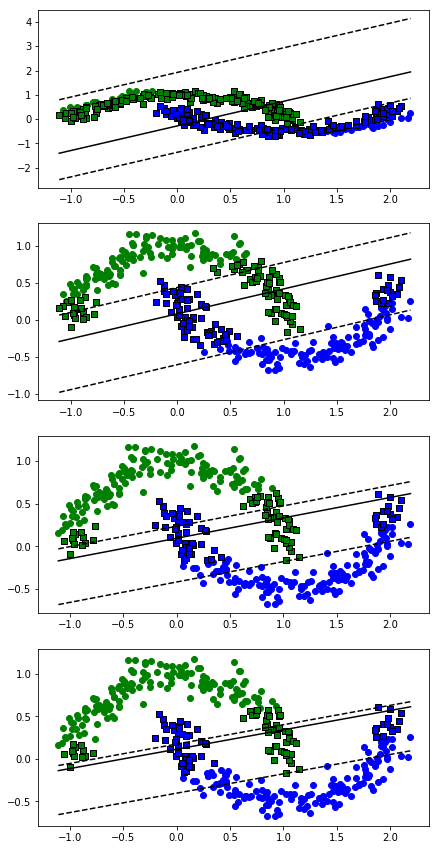

In [794]:
fig, axes = plt.subplots(4,1,figsize=(7,15))
C=[0.005,0.1,1,10]
X,y = moons

for k in range(4):
    clf = svm.SVC(C=C[k],kernel='linear')
    clf.fit(X,y) 
    w = clf.coef_[0]
    a = - w[0] / w[1]
    xx = np.linspace(X.T[0].min(), X.T[0].max())
    yy = a * xx - clf.intercept_[0] / w[1]
    yy_up = a * xx - (-1 - clf.intercept_[0]) / w[1]
    yy_down = a * xx - (1 - clf.intercept_[0]) / w[1]


    i=np.where(y==1)
    j=np.where(y==0)
    ii=np.where(y[clf.support_]==1)
    jj=np.where(y[clf.support_]==0)

    axes[k].scatter(X[i].T[0], X[i].T[1], c='b')
    axes[k].scatter(X[j].T[0], X[j].T[1], c='g')
    axes[k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='b',marker='s', edgecolors='k')
    axes[k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='g',marker='s', edgecolors='k')
    axes[k].plot(xx, yy,'k-')
    axes[k].plot(xx, yy_up,'k--')
    axes[k].plot(xx, yy_down,'k--')
plt.show()

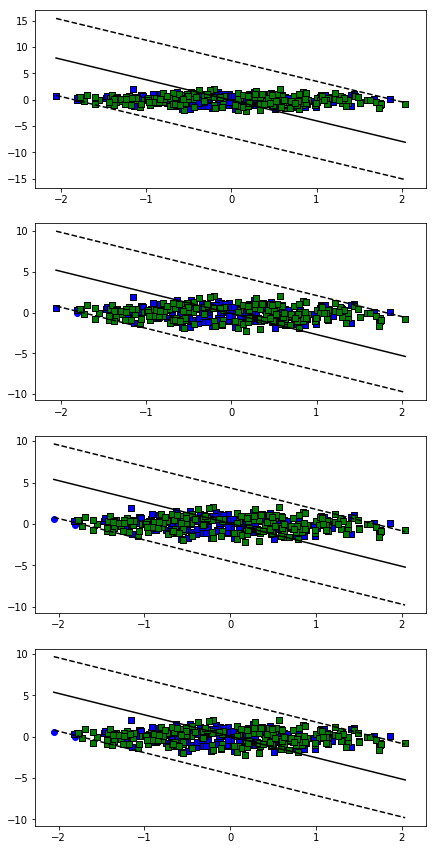

In [797]:
fig, axes = plt.subplots(4,1,figsize=(7,15))
C=[0.1,1,10,1000]
X,y = circles

for k in range(4):
    clf = svm.SVC(C=C[k],kernel='linear')
    clf.fit(X,y) 
    w = clf.coef_[0]
    a = - w[0] / w[1]
    xx = np.linspace(X.T[0].min(), X.T[0].max())
    yy = a * xx - clf.intercept_[0] / w[1]
    yy_up = a * xx - (-1 - clf.intercept_[0]) / w[1]
    yy_down = a * xx - (1 - clf.intercept_[0]) / w[1]


    i=np.where(y==1)
    j=np.where(y==0)
    ii=np.where(y[clf.support_]==1)
    jj=np.where(y[clf.support_]==0)

    axes[k].scatter(X[i].T[0], X[i].T[1], c='b')
    axes[k].scatter(X[j].T[0], X[j].T[1], c='g')
    axes[k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='b',marker='s', edgecolors='k')
    axes[k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='g',marker='s', edgecolors='k')
    axes[k].plot(xx, yy,'k-')
    axes[k].plot(xx, yy_up,'k--')
    axes[k].plot(xx, yy_down,'k--')
plt.show()

**(0.5 балла)** Как зависит число опорных векторов от параметра $C$ для различных выборок?

Чем больше С, тем меньше регуляризация и больше опорных векторов.

#### Явное преобразование признаков

Как и в случае с линейной регрессией, когда оптимальная разделяющая гиперплоскость не является линейной, данная модель является очень грубым решением. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, аналогичное добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

### Задание 7.

**(0.5 балла)** На тех же данных, используя явное преобразование признаков, обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные векторы точками другой формы или большего размера. Проделайте это для разных значений параметра $C$.

In [798]:
X,y = linearly_separable
clf = svm.SVC(kernel='rbf')
clf.fit(X,y) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

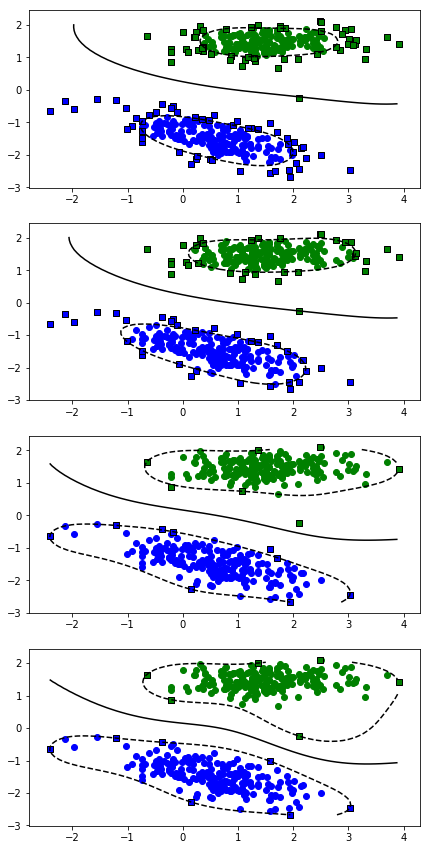

In [853]:
fig, axes = plt.subplots(4,1,figsize=(7,15))
C=[0.05,0.1,1,10]
X,y = linearly_separable

for k in range(4):
    clf = svm.SVC(C=C[k],kernel='rbf')
    clf.fit(X,y)  
    
    xx, yy = np.meshgrid(np.arange(np.min(X,axis=0)[0], np.max(X,axis=0)[0],0.1), \
                         np.arange(np.min(X,axis=0)[1], np.max(X,axis=0)[1],0.1))
    
    Z=clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    i=np.where(y==1)
    j=np.where(y==0)
    ii=np.where(y[clf.support_]==1)
    jj=np.where(y[clf.support_]==0)

    axes[k].scatter(X[i].T[0], X[i].T[1], c='b')
    axes[k].scatter(X[j].T[0], X[j].T[1], c='g')
    axes[k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='b',marker='s', edgecolors='k')
    axes[k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='g',marker='s', edgecolors='k')
    axes[k].contour(xx, yy, Z,levels=[-1,0,1],colors='k',linestyles=['dashed','solid','dashed'])
    
plt.show()

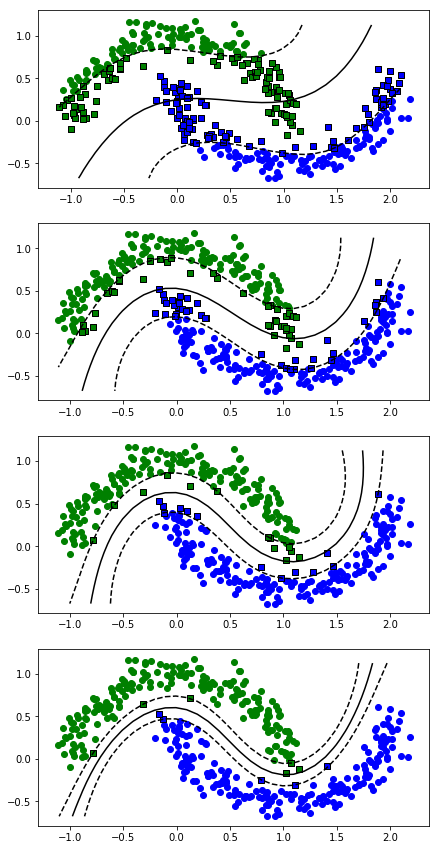

In [855]:
fig, axes = plt.subplots(4,1,figsize=(7,15))
C=[0.1,1,10,100]
X,y = moons

for k in range(4):
    clf = svm.SVC(C=C[k],kernel='rbf')
    clf.fit(X,y)  
    
    xx, yy = np.meshgrid(np.arange(np.min(X,axis=0)[0], np.max(X,axis=0)[0],0.1), \
                         np.arange(np.min(X,axis=0)[1], np.max(X,axis=0)[1],0.1))
    
    Z=clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    i=np.where(y==1)
    j=np.where(y==0)
    ii=np.where(y[clf.support_]==1)
    jj=np.where(y[clf.support_]==0)

    axes[k].scatter(X[i].T[0], X[i].T[1], c='b')
    axes[k].scatter(X[j].T[0], X[j].T[1], c='g')
    axes[k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='b',marker='s', edgecolors='k')
    axes[k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='g',marker='s', edgecolors='k')
    axes[k].contour(xx, yy, Z,levels=[-1,0,1],colors='k',linestyles=['dashed','solid','dashed'])
    
plt.show()

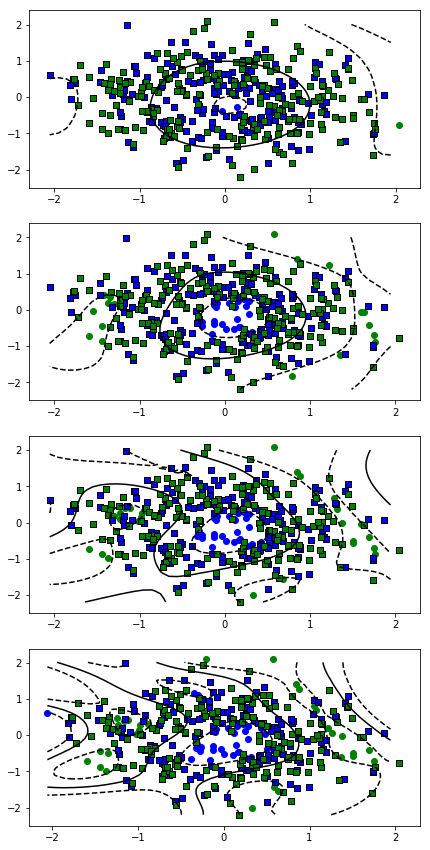

In [857]:
fig, axes = plt.subplots(4,1,figsize=(7,15))
C=[0.1,1,10,100]
X,y = circles

for k in range(4):
    clf = svm.SVC(C=C[k],kernel='rbf')
    clf.fit(X,y)  
    
    xx, yy = np.meshgrid(np.arange(np.min(X,axis=0)[0], np.max(X,axis=0)[0],0.1), \
                         np.arange(np.min(X,axis=0)[1], np.max(X,axis=0)[1],0.1))
    
    Z=clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    i=np.where(y==1)
    j=np.where(y==0)
    ii=np.where(y[clf.support_]==1)
    jj=np.where(y[clf.support_]==0)

    axes[k].scatter(X[i].T[0], X[i].T[1], c='b')
    axes[k].scatter(X[j].T[0], X[j].T[1], c='g')
    axes[k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='b',marker='s', edgecolors='k')
    axes[k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='g',marker='s', edgecolors='k')
    axes[k].contour(xx, yy, Z,levels=[-1,0,1],colors='k',linestyles=['dashed','solid','dashed'])
    
plt.show()

## Двойственный переход и Ядровой SVM

![](http://i.imgur.com/bJAzRCt.png)

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте, принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \leqslant \alpha_n \leqslant C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно, верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит, для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит векторы признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в векторы очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 


В этом задании используйте класс $sklearn.svm.SVC$, меняя тип ядра. 

### Задание 8.

**(1 балл)** Протестируйте на предыдущих двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные векторы точками другой формы или большего размера. Попробуйте следующие ядровые функции:
- линейная: $k(x, x') = x^Tx'$
- полиномиальная: $k(x, x') = (x^Tx' + 1)^d$ с различными степенями $d = 2,3,\dots$
- Гауссовская-RBF: $k(x, x') = \exp(-\sigma\|x - x'\|^2)$

Ответьте на следующие вопросы:
 - Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $d$?
 - Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\sigma$? Поварьируйте параметры $C$ и $\sigma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

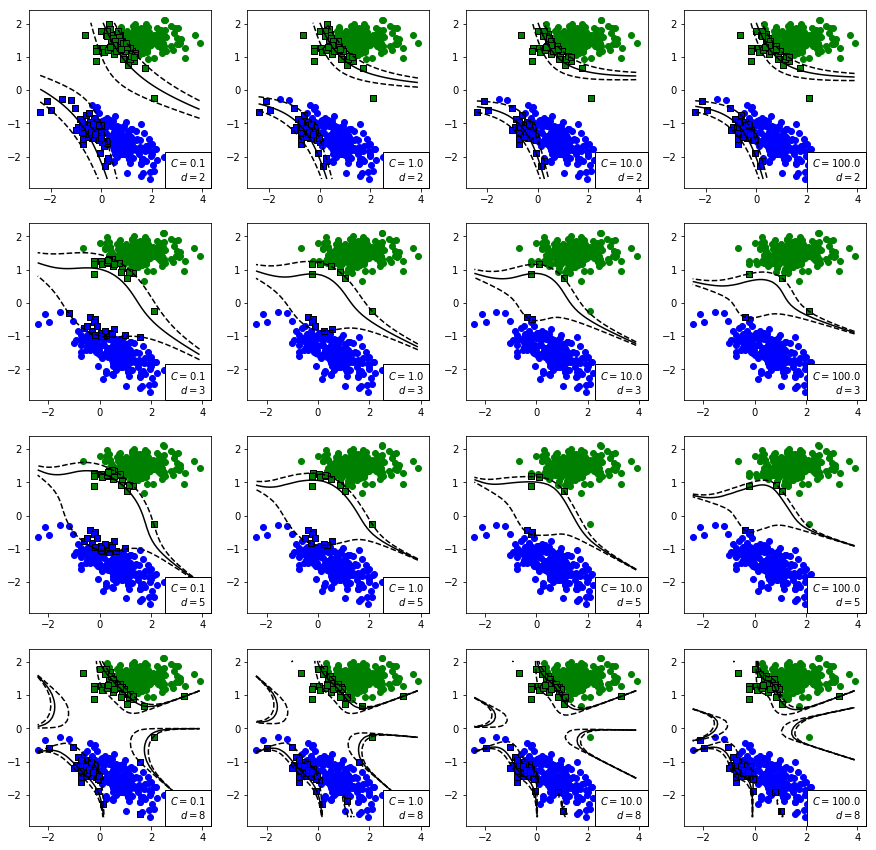

In [922]:
fig, axes = plt.subplots(4,4,figsize=(15,15))
d=[2,3,5,8]
C=[0.1,1,10,100]
X,y = linearly_separable

for k in range(4):
    for l in range(4):

        clf = svm.SVC(C=C[k],kernel='poly',degree=d[l])
        clf.fit(X,y)  

        xx, yy = np.meshgrid(np.arange(np.min(X,axis=0)[0], np.max(X,axis=0)[0],0.1), \
                             np.arange(np.min(X,axis=0)[1], np.max(X,axis=0)[1],0.1))

        Z=clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        i=np.where(y==1)
        j=np.where(y==0)
        ii=np.where(y[clf.support_]==1)
        jj=np.where(y[clf.support_]==0)

        axes[l,k].scatter(X[i].T[0], X[i].T[1], c='b')
        axes[l,k].scatter(X[j].T[0], X[j].T[1], c='g')
        axes[l,k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='b',marker='s', edgecolors='k')
        axes[l,k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='g',marker='s', edgecolors='k')
        axes[l,k].contour(xx, yy, Z,levels=[-1,0,1],colors='k',linestyles=['dashed','solid','dashed'])
        axes[l,k].annotate('$C=%.1f$\n$d=%.d$'%(C[k],d[l]), xy=(1, 0), xycoords='axes fraction', 
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom',bbox={'facecolor':'white', 'pad':5})

plt.show()

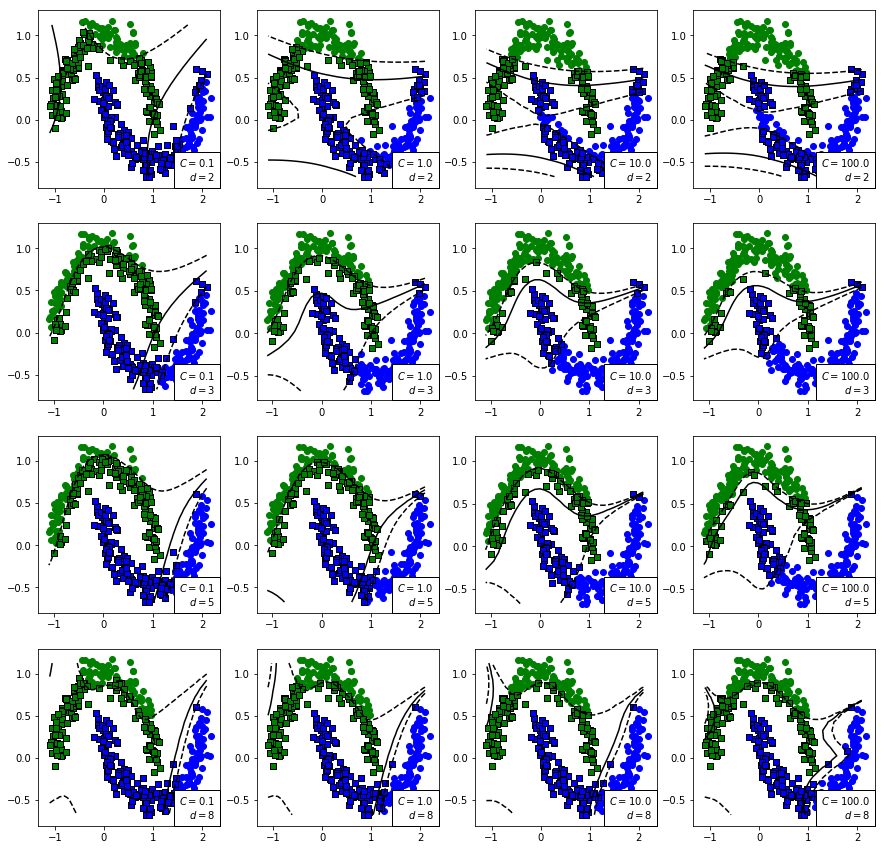

In [923]:
fig, axes = plt.subplots(4,4,figsize=(15,15))
d=[2,3,5,8]
C=[0.1,1,10,100]
X,y = moons

for k in range(4):
    for l in range(4):

        clf = svm.SVC(C=C[k],kernel='poly',degree=d[l])
        clf.fit(X,y)  

        xx, yy = np.meshgrid(np.arange(np.min(X,axis=0)[0], np.max(X,axis=0)[0],0.1), \
                             np.arange(np.min(X,axis=0)[1], np.max(X,axis=0)[1],0.1))

        Z=clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        i=np.where(y==1)
        j=np.where(y==0)
        ii=np.where(y[clf.support_]==1)
        jj=np.where(y[clf.support_]==0)

        axes[l,k].scatter(X[i].T[0], X[i].T[1], c='b')
        axes[l,k].scatter(X[j].T[0], X[j].T[1], c='g')
        axes[l,k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='b',marker='s', edgecolors='k')
        axes[l,k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='g',marker='s', edgecolors='k')
        axes[l,k].contour(xx, yy, Z,levels=[-1,0,1],colors='k',linestyles=['dashed','solid','dashed'])
        axes[l,k].annotate('$C=%.1f$\n$d=%.d$'%(C[k],d[l]), xy=(1, 0), xycoords='axes fraction', 
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom',bbox={'facecolor':'white', 'pad':5})

plt.show()

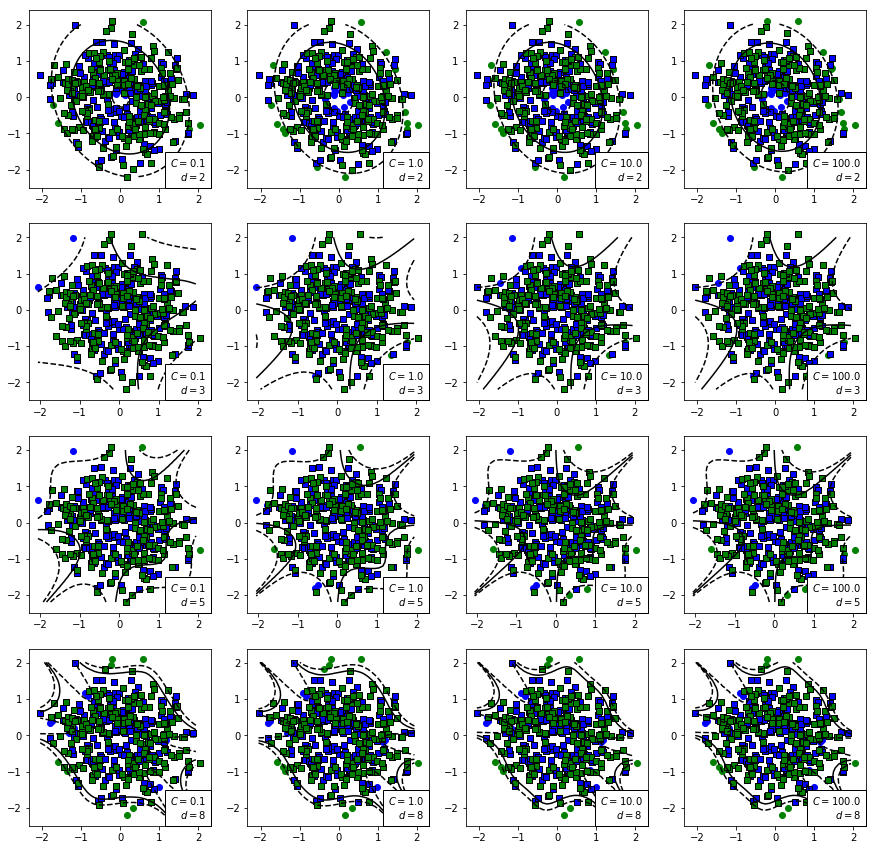

In [924]:
fig, axes = plt.subplots(4,4,figsize=(15,15))
d=[2,3,5,8]
C=[0.1,1,10,100]
X,y = circles

for k in range(4):
    for l in range(4):

        clf = svm.SVC(C=C[k],kernel='poly',degree=d[l])
        clf.fit(X,y)  

        xx, yy = np.meshgrid(np.arange(np.min(X,axis=0)[0], np.max(X,axis=0)[0],0.1), \
                             np.arange(np.min(X,axis=0)[1], np.max(X,axis=0)[1],0.1))

        Z=clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        i=np.where(y==1)
        j=np.where(y==0)
        ii=np.where(y[clf.support_]==1)
        jj=np.where(y[clf.support_]==0)

        axes[l,k].scatter(X[i].T[0], X[i].T[1], c='b')
        axes[l,k].scatter(X[j].T[0], X[j].T[1], c='g')
        axes[l,k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='b',marker='s', edgecolors='k')
        axes[l,k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='g',marker='s', edgecolors='k')
        axes[l,k].contour(xx, yy, Z,levels=[-1,0,1],colors='k',linestyles=['dashed','solid','dashed'])
        axes[l,k].annotate('$C=%.1f$\n$d=%.d$'%(C[k],d[l]), xy=(1, 0), xycoords='axes fraction', 
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom',bbox={'facecolor':'white', 'pad':5})

plt.show()

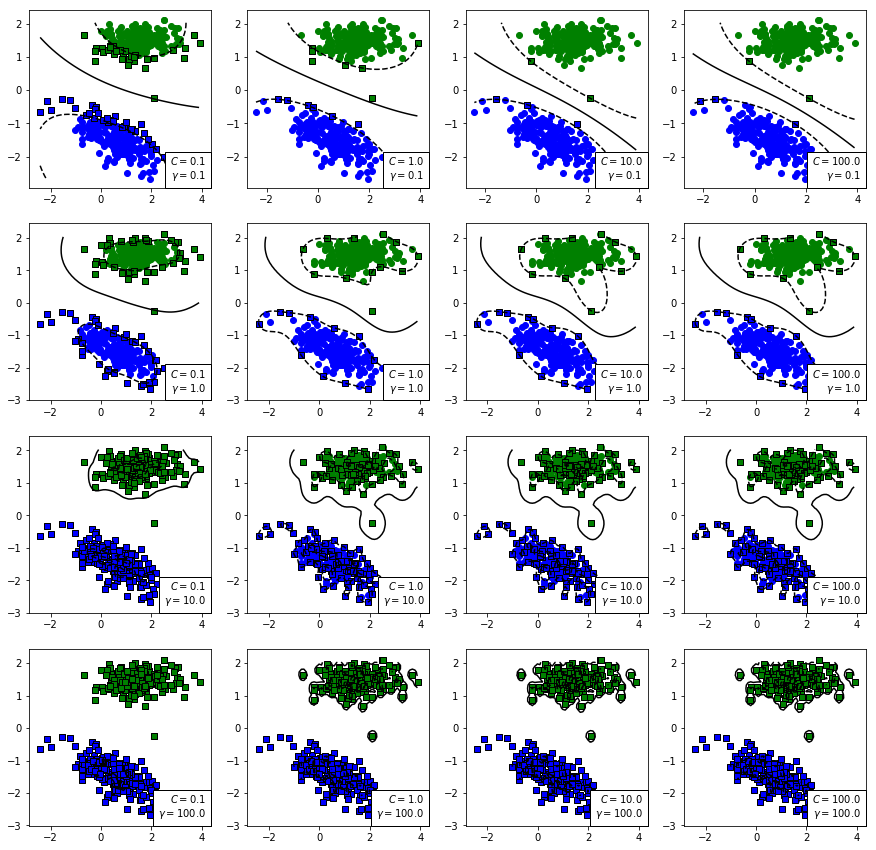

In [929]:
fig, axes = plt.subplots(4,4,figsize=(15,15))
C=[0.1,1,10,100]
gamma=[0.1,1,10,100]
X,y = linearly_separable

for k in range(4):
    for l in range(4):

        clf = svm.SVC(C=C[k],kernel='rbf',gamma=gamma[l])
        clf.fit(X,y)  

        xx, yy = np.meshgrid(np.arange(np.min(X,axis=0)[0], np.max(X,axis=0)[0],0.1), \
                             np.arange(np.min(X,axis=0)[1], np.max(X,axis=0)[1],0.1))

        Z=clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        i=np.where(y==1)
        j=np.where(y==0)
        ii=np.where(y[clf.support_]==1)
        jj=np.where(y[clf.support_]==0)

        axes[l,k].scatter(X[i].T[0], X[i].T[1], c='b')
        axes[l,k].scatter(X[j].T[0], X[j].T[1], c='g')
        axes[l,k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='b',marker='s', edgecolors='k')
        axes[l,k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='g',marker='s', edgecolors='k')
        axes[l,k].contour(xx, yy, Z,levels=[-1,0,1],colors='k',linestyles=['dashed','solid','dashed'])
        axes[l,k].annotate('$C=%.1f$\n$\gamma=%.1f$'%(C[k],gamma[l]), xy=(1, 0), xycoords='axes fraction', 
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom',bbox={'facecolor':'white', 'pad':5})

plt.show()

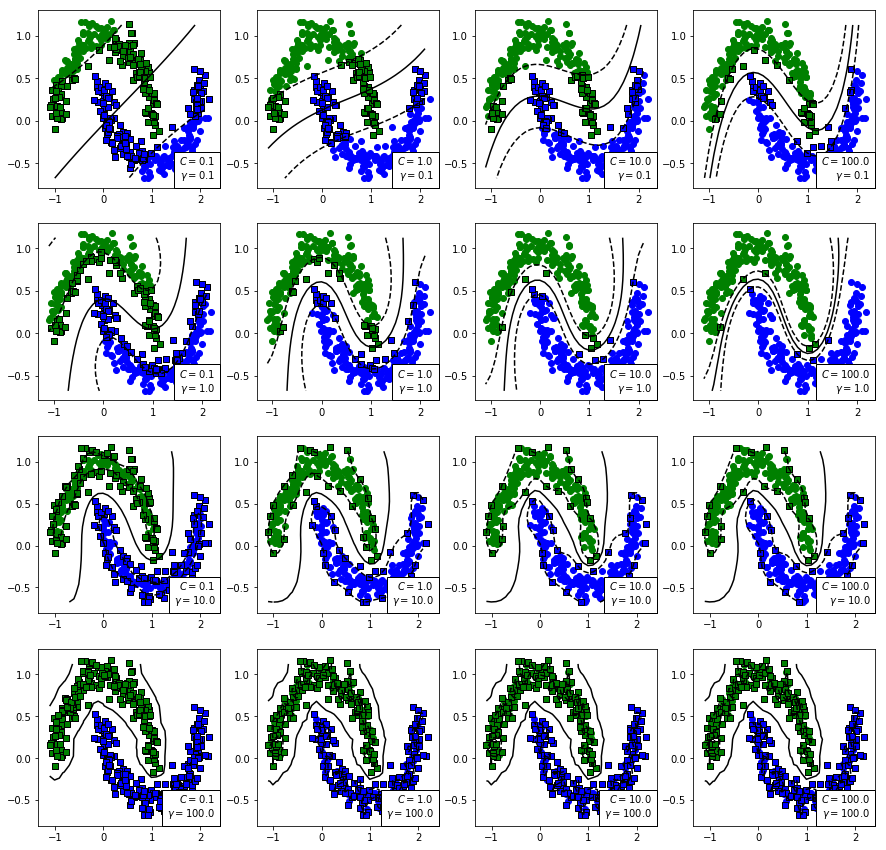

In [930]:
fig, axes = plt.subplots(4,4,figsize=(15,15))
C=[0.1,1,10,100]
gamma=[0.1,1,10,100]
X,y = moons

for k in range(4):
    for l in range(4):

        clf = svm.SVC(C=C[k],kernel='rbf',gamma=gamma[l])
        clf.fit(X,y)  

        xx, yy = np.meshgrid(np.arange(np.min(X,axis=0)[0], np.max(X,axis=0)[0],0.1), \
                             np.arange(np.min(X,axis=0)[1], np.max(X,axis=0)[1],0.1))

        Z=clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        i=np.where(y==1)
        j=np.where(y==0)
        ii=np.where(y[clf.support_]==1)
        jj=np.where(y[clf.support_]==0)

        axes[l,k].scatter(X[i].T[0], X[i].T[1], c='b')
        axes[l,k].scatter(X[j].T[0], X[j].T[1], c='g')
        axes[l,k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='b',marker='s', edgecolors='k')
        axes[l,k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='g',marker='s', edgecolors='k')
        axes[l,k].contour(xx, yy, Z,levels=[-1,0,1],colors='k',linestyles=['dashed','solid','dashed'])
        axes[l,k].annotate('$C=%.1f$\n$\gamma=%.1f$'%(C[k],gamma[l]), xy=(1, 0), xycoords='axes fraction', 
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom',bbox={'facecolor':'white', 'pad':5})

plt.show()

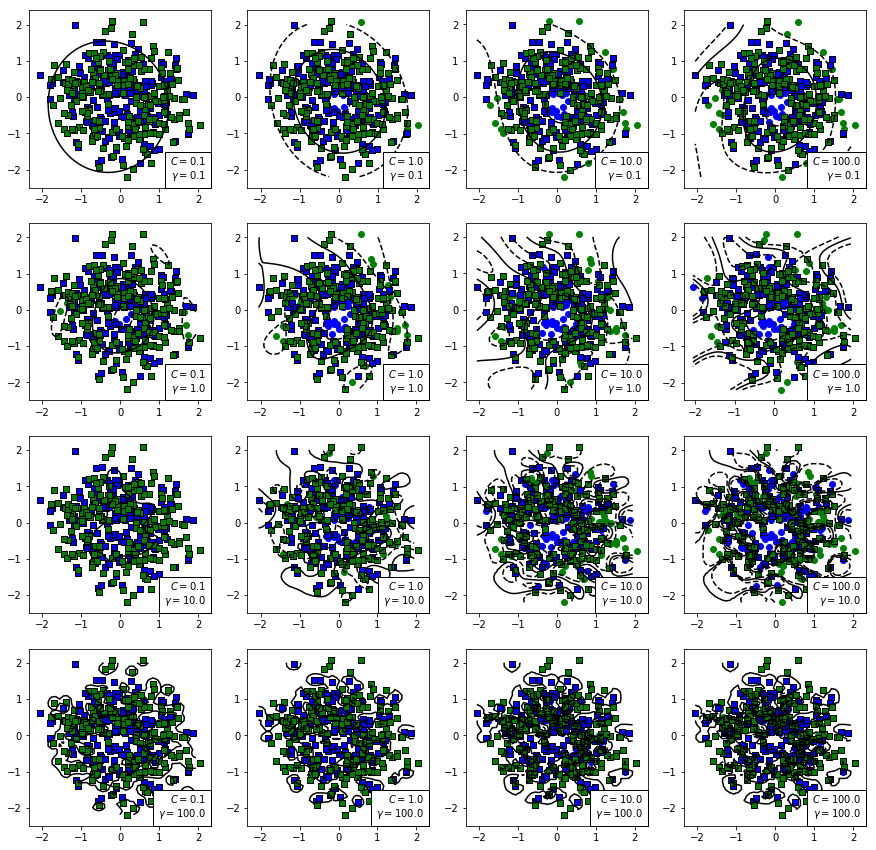

In [931]:
fig, axes = plt.subplots(4,4,figsize=(15,15))
C=[0.1,1,10,100]
gamma=[0.1,1,10,100]
X,y = circles

for k in range(4):
    for l in range(4):

        clf = svm.SVC(C=C[k],kernel='rbf',gamma=gamma[l])
        clf.fit(X,y)  

        xx, yy = np.meshgrid(np.arange(np.min(X,axis=0)[0], np.max(X,axis=0)[0],0.1), \
                             np.arange(np.min(X,axis=0)[1], np.max(X,axis=0)[1],0.1))

        Z=clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        i=np.where(y==1)
        j=np.where(y==0)
        ii=np.where(y[clf.support_]==1)
        jj=np.where(y[clf.support_]==0)

        axes[l,k].scatter(X[i].T[0], X[i].T[1], c='b')
        axes[l,k].scatter(X[j].T[0], X[j].T[1], c='g')
        axes[l,k].scatter(X[clf.support_][ii].T[0], X[clf.support_][ii].T[1], c='b',marker='s', edgecolors='k')
        axes[l,k].scatter(X[clf.support_][jj].T[0], X[clf.support_][jj].T[1], c='g',marker='s', edgecolors='k')
        axes[l,k].contour(xx, yy, Z,levels=[-1,0,1],colors='k',linestyles=['dashed','solid','dashed'])
        axes[l,k].annotate('$C=%.1f$\n$\gamma=%.1f$'%(C[k],gamma[l]), xy=(1, 0), xycoords='axes fraction', 
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom',bbox={'facecolor':'white', 'pad':5})

plt.show()

## Выводы

**(1 балл)** В этой работе вы рассмотрели некоторые линейные модели машинного обучения, а также способы их обучения. Ответьте на следующие вопросы:

 - Какие есть достоинства у рассмотренных моделей? Дайте свой ответ для каждой модели.
 - Каким общим недостатком обладают данные модели? Какие есть способы его устранения? В чем может заключаться сложность использования этих подходов?
 - В чем заключаются различия с точки зрения обучения алгоритмов? Какие есть достоинства и недостатки у рассмотренных методов обучения?
 - Предположите, в каком случае каждый из алгоритмов будет работать лучше: при большом/небольшом количестве данных? Поясните почему. 

Метод градиентного спуска универсален: им можно минимизировать дифференцируемые функции потерь, в т.ч. с нелинейным ядром. При помощи стозастического градиентного спуска и его модификаций можно ускорить работу алгоритма и избежать проблемы осцилирования в окрестности минимума. Динамическое обучение и обучение на больших данных так же реализуемо. Логистическая регрессия дает вероятностную интерпретацию задачи, следовательно, она удобна для оценки рисков и задач с временными рядами. Результаты линейной регрессии интерпретируемы, и она хорошо работает с большим количеством признаков. Модель усложняется добавлением разных признаков. В svm возможно использовать нелинейные ядра, что позволяет усложнить классификатор. Поэтому разделяющая поверхность позволяет хорошо описать данные. В общем, линейне классификаторы работают быстро

Метод градиентного спуска не всегда сходится и может застрять в локальных минимумах. Линейные методы не делают преобразований признаков, условия на них и их комбинации - приходится самостоятельно генерировать признаки и нормитровать те, что есть.  Сложные закономерности этими методами сложно уловить. Результат зависит от выборки, методы чувствителны к выбросам, регуляризация помогает от переобучения, но подбор оптимальных гиперпараметров может быть сложным, если данные плохо поддаются визуализации

Градиентый спуск для логистической и линейной регрессий дает хороший результат, но сходимость может быть долгой или может произойти застрявание в локальном минимуме. Скорость схождения sgd выше, но он может осцилировать в окрестности минимума. Точное решение линейной регрессии работает плохо. Если признаки мультиколлинеарны, может возникнуть проблема в обращении матриц. Задача квадратичного программирования в svm имеет единственное решение, алгоритм сходится, но есть вероятность большой вычислительной сложности.

Большой объем данных делает выборку более устойчивой, улучшает результаты. В линейной регрессии приходится делать обращение большой матрицы - и это имеет большую сложность. 
На большом объеме в SVM  происходит переход в большую размерность, поэтому реализация тоже сложна. Стохастический градиентный спуск на больших данных ускоряет работу. На малых же данных sgd бесполезен. На малых данных линейная регрессия работает хорошо, но чувствительна к выбросам.